In [1]:
import multiprocessing as mp
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import mabs

sns.set_theme()

n = 1000
mus = np.linspace(0, 1, 100)

normal_priors = np.array(
    [
        [[0, 1], [0, 1]],
        [[0, 1], [0.5, 1]],
        [[0.5, 1], [0, 1]],
        [[0, 0.1], [0.5, 0.1]],
        [[0.5, 0.1], [0, 0.1]],
    ]
)

In [2]:
def experiment(mu, n, prior_a, prior_b):
    exp_regret = np.empty(1000)
    for i in range(1000):
        arms = [
            mabs.arms.NormalArm(0, 1),
            mabs.arms.NormalArm(mu, 1),
        ]
        env = mabs.envs.ThompsonSampling("normal")
        env.arms = arms
        env.prior_params = {
            arms[0]: {"mu": prior_a[0], "sigma": prior_a[1] ** 0.5},
            arms[1]: {"mu": prior_b[0], "sigma": prior_b[1] ** 0.5},
        }

        for _ in range(n):
            env.act()
        exp_regret[i] = env.regret

    return exp_regret, mu, n, str(prior_a) + str(prior_b)

In [3]:
regrets = []
args = []

for prior in normal_priors:
    args += [(mu, n, prior[0], prior[1]) for mu in mus]
with mp.Pool(32) as p:
    result = p.starmap(experiment, args)

with open("result.pkl", "wb") as f:
    pickle.dump(result, f)

In [5]:
with open("result.pkl", "rb") as f:
    result_raw = pickle.load(f)

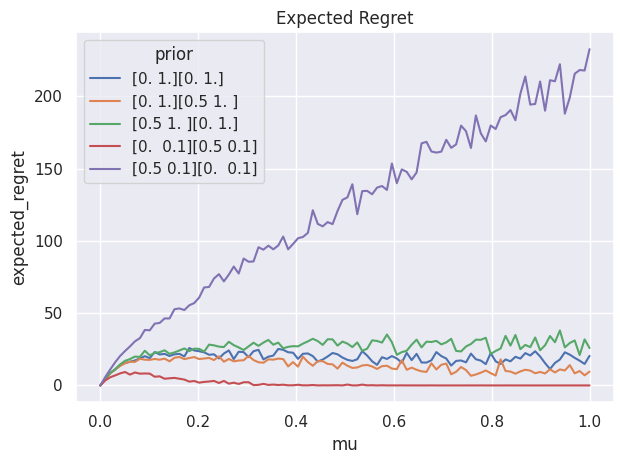

In [6]:
mean_regret = [(regret.mean(), mu, n, prior) for regret, mu, n, prior in result_raw]
mean_regret_df = pd.DataFrame(
    mean_regret, columns=["expected_regret", "mu", "n", "prior"]
)
sns.lineplot(data=mean_regret_df, x="mu", y="expected_regret", hue="prior")
plt.title("Expected Regret")
plt.tight_layout()
plt.savefig("ts_normal_mean.pdf")

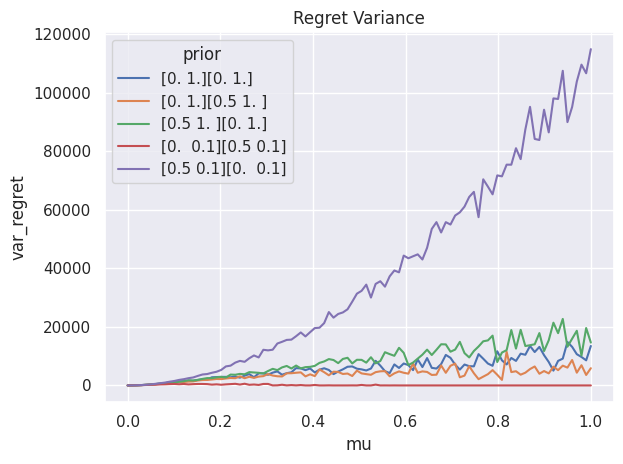

In [7]:
var_regret = [(regret.var(), mu, n, prior) for regret, mu, n, prior in result_raw]
var_regret_df = pd.DataFrame(var_regret, columns=["var_regret", "mu", "n", "prior"])
sns.lineplot(data=var_regret_df, x="mu", y="var_regret", hue="prior")
plt.title("Regret Variance")
plt.tight_layout()
plt.savefig("ts_normal_var.pdf")